In [1]:
!pip install ta

import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random Forest

In [2]:
np.random.seed(1111)

df = pd.read_csv('Database.csv', index_col=0)
df.index = pd.to_datetime(df.index, format="%d/%m/%Y %H:%M:%S")
df.sort_index()
df

,Open,High,Low,Close,Volume,Return,Output
Date,,,,,,,
2010-01-04 16:56:00,11.89,12.24,11.87,12.16,3601600,0.06,1
2010-01-05 16:56:00,12.23,12.27,11.93,12.10,4246200,0.10,1
2010-01-06 16:56:00,12.06,12.15,11.93,12.00,3736000,0.03,1
2010-01-07 16:56:00,11.94,12.02,11.85,11.97,2201800,0.02,1
2010-01-08 16:56:00,12.03,12.03,11.84,11.95,2390300,-0.01,0
...,...,...,...,...,...,...,...
2023-08-10 16:56:00,15.43,15.62,15.36,15.46,27521100,0.09,1
2023-08-11 16:56:00,15.50,15.57,15.28,15.37,44038100,0.08,1
2023-08-14 16:56:00,15.31,15.37,15.18,15.29,27965700,-0.04,0


## Feature Engineering

### Date Feature

In [3]:
dataDates = df.index

df["year"] =  dataDates.year
df["month"] = dataDates.month
df["day"] = dataDates.day
df["weekday"] = dataDates.weekday
df["quarter"] =  dataDates.quarter
df

,Open,High,Low,Close,Volume,Return,Output,year,month,day,weekday,quarter
Date,,,,,,,,,,,,
2010-01-04 16:56:00,11.89,12.24,11.87,12.16,3601600,0.06,1,2010,1,4,0,1
2010-01-05 16:56:00,12.23,12.27,11.93,12.10,4246200,0.10,1,2010,1,5,1,1
2010-01-06 16:56:00,12.06,12.15,11.93,12.00,3736000,0.03,1,2010,1,6,2,1
2010-01-07 16:56:00,11.94,12.02,11.85,11.97,2201800,0.02,1,2010,1,7,3,1
2010-01-08 16:56:00,12.03,12.03,11.84,11.95,2390300,-0.01,0,2010,1,8,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10 16:56:00,15.43,15.62,15.36,15.46,27521100,0.09,1,2023,8,10,3,3
2023-08-11 16:56:00,15.50,15.57,15.28,15.37,44038100,0.08,1,2023,8,11,4,3
2023-08-14 16:56:00,15.31,15.37,15.18,15.29,27965700,-0.04,0,2023,8,14,0,3


### Time Series Feature



In [4]:
open = df.Open
high = df.High
low = df.Low
close = df.Close
volume = df.Volume

In [5]:
df['Close_Lag_1'] = close.shift(1)
#df['Log_Volume'] = np.log(df.Volume)
df['Volume_diff'] = volume.diff()
df['Volume_Percentage_Change'] = volume.pct_change()
df["Daily_Return"] = close.pct_change() * 100
df['Close_Rolling_Mean_50'] = close.rolling(window=50).mean()
df['VWAP'] = (close * volume).cumsum() / volume.cumsum()
df['SMA_50'] = close.rolling(window=50).mean()
df["Standard_Deviation_50"] = df["Close"].rolling(window=50).std()
df['Upper_Band'] = df['SMA_50'] + (df["Standard_Deviation_50"] * 2)
df['Lower_Band'] = df['SMA_50'] - (df["Standard_Deviation_50"] * 2)

horizons = [2, 3, 4, 5, 10, 22, 66]
#new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    rolling_std = df.rolling(horizon).std()
    expanding_averages = df.expanding(horizon).mean()
    expanding_std = df.expanding(horizon).std()
    exponential_mov_avg = df.ewm(span=horizon, adjust=False).mean()

    close_ratio_column = f"Close_Ratio_{horizon}"
    df[close_ratio_column] = df["Close"] / rolling_averages["Close"]

    # Rolling Avg
    close_rolling_mean_column = f"Close_Rolling_Mean_{horizon}"
    df[close_rolling_mean_column] = rolling_averages["Close"]

    # Rolling Standard Deviation
    close_rolling_std_column = f"Close_Rolling_Std_{horizon}"
    df[close_rolling_std_column] = rolling_std["Close"]

    df['Upper_Band'] = df[close_rolling_mean_column] + (df[close_rolling_std_column] * 2)
    df['Lower_Band'] = df[close_rolling_mean_column] - (df[close_rolling_std_column] * 2)

    # Expanding Avg
    close_expanding_mean_column = f"Close_Expanding_Mean_{horizon}"
    df[close_expanding_mean_column] = expanding_averages["Close"]

    # Expanding Standard Deviation
    close_expanding_std_column = f"Close_Expanding_Mean_{horizon}"
    df[close_expanding_std_column] = expanding_std["Close"]

    # Lag Feature
    close_lag_column = f"Close_Lag_{horizon}"
    df[close_lag_column] = close.shift(horizon)

    # Exponential Moving Avg
    exponential_moving_avg_column = f"Exponential_Moving_Avg_{horizon}"
    df[exponential_moving_avg_column] = exponential_mov_avg["Close"]

    # Log Volume
    log_volume_column = f"Log_Volume_{horizon}"
    df[log_volume_column] = df.Volume.rolling(horizon).mean().apply(np.log)

    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Output"]

In [6]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df.head()

,Open,High,Low,Close,Volume,Return,Output,year,month,day,...,Log_Volume_22,Trend_22,Close_Ratio_66,Close_Rolling_Mean_66,Close_Rolling_Std_66,Close_Expanding_Mean_66,Close_Lag_66,Exponential_Moving_Avg_66,Log_Volume_66,Trend_66
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-12 16:56:00,11.92,12.03,11.80,11.82,4714700,0.11,1,2010,4,12,...,14.987303,11.0,1.036732,11.401212,0.345015,0.354719,12.16,11.504075,15.146534,33.0
2010-04-13 16:56:00,11.82,11.88,11.71,11.71,3072300,-0.04,0,2010,4,13,...,14.998424,12.0,1.027616,11.395303,0.336087,0.353905,12.10,11.510222,15.141824,33.0
2010-04-14 16:56:00,11.71,11.81,11.61,11.75,3678900,0.16,1,2010,4,14,...,15.009908,11.0,1.031469,11.391515,0.330530,0.353574,12.00,11.517380,15.141594,32.0
2010-04-15 16:56:00,11.75,11.78,11.55,11.59,4276900,0.24,1,2010,4,15,...,15.033479,11.0,1.017938,11.385758,0.323534,0.351578,11.97,11.519547,15.149908,32.0
2010-04-16 16:56:00,11.55,11.55,11.26,11.35,5313600,0.10,1,2010,4,16,...,15.102493,12.0,0.997656,11.376667,0.315772,0.349169,11.95,11.514486,15.161503,32.0


### Technical Indicator Feature

In [ ]:
# Money Flow Multiplier: [(Close - Low) - (High - Close)] /(High - Low)
money_flow_mult = ((close - low) - (high - close)) /(high - low)
df['money_flow_mult'] = money_flow_mult

# Money Flow Volume: Money Flow Multiplier x Volume for the Period
money_flow_volume = money_flow_mult * volume
df['money_flow_volume'] = money_flow_volume

# ADL(ADI): Previous ADL + Current Period's Money Flow Volume
adi = money_flow_volume.cumsum()
df['adi'] = adi

# Chaikin Money Flow
cmf = money_flow_volume.rolling(20).sum() / volume.rolling(20).sum()
df['chaikin_money_flow'] = adi

# Simple Moving Average (SMA)
sma_5 = close.transform(lambda x: x.rolling(window = 5).mean())
df['sma_5'] = sma_5
sma_15 = close.transform(lambda x: x.rolling(window = 15).mean())
df['sma_15'] = sma_15

SMA_ratio = sma_15/sma_5
df['SMA_ratio'] = SMA_ratio

# Simple Moving Average Volume
sma_5_volume = volume.transform(lambda x: x.rolling(window = 5).mean())
df['sma_5_volume'] = sma_5_volume
sma_15_volume = close.transform(lambda x: x.rolling(window = 15).mean())
df['sma_15_volume'] = sma_15_volume

SMA_ratio_volume = sma_15_volume/sma_5_volume
df['SMA_ratio_volume'] = SMA_ratio_volume

# Exponential Moving Average (EMA)
df['EMA_5'] = ta.trend.ema_indicator(df['Close'], window=5)
df['EMA_14'] = ta.trend.ema_indicator(df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
df['MACD'] = ta.trend.macd_diff(df['Close'])

# Relative Strength Index (RSI)
df['RSI_5'] = ta.momentum.rsi(df['Close'], window=5)
df['RSI_14'] = ta.momentum.rsi(df['Close'], window=14)

# ATR
atr = ta.volatility.average_true_range(high,low,close,window=14)
df['atr'] = atr

# KCPI
kcpi = ta.volatility.keltner_channel_pband(high,low,close)
df['kcpi'] = kcpi

# DCPI
dcpi = ta.volatility.donchian_channel_pband(high,low,close)
df['dcpi'] = dcpi

# BBPI
bbpi = ta.volatility.bollinger_pband(close,window=20)
df['bbpi'] = bbpi

# EOM
eom = ta.volume.ease_of_movement(high,low,volume,1)
df['eom'] = eom

# Bollinger Bands
df['BB_High'] = ta.volatility.bollinger_hband(df['Close'])
df['BB_Low'] = ta.volatility.bollinger_lband(df['Close'])

# On-Balance Volume (OBV)
df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])

# Money Flow Index (MFI)
df['MFI'] = ta.volume.money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'])



In [ ]:
########## Time Series Features ##########

#Open Lag
#df['open_lag_1'] = open.shift(1)
#df['open_lag_2'] = open.shift(2)
#df['open_lag_3'] = open.shift(3)
#df['open_lag_4'] = open.shift(4)
#df['open_lag_5'] = open.shift(5)
#df['open_lag_10'] = open.shift(10)
#df['open_lag_22'] = open.shift(22)

#Close Lag
#df['close_lag_1'] = close.shift(1)
#df['close_lag_2'] = close.shift(2)
#df['close_lag_3'] = close.shift(3)
#df['close_lag_4'] = close.shift(4)
#df['close_lag_5'] = close.shift(5)
#df['close_lag_10'] = close.shift(10)
#df['close_lag_22'] = close.shift(22)

# Window Feature
# Standard Deviation
#rolling_std_3 = close.rolling(3).std()
#df['rolling_std_3'] = rolling_std_3
#rolling_std_5 = close.rolling(5).std()
#df['rolling_std_5'] = rolling_std_5
#rolling_std_22 = close.rolling(22).std()
#df['rolling_std_22'] = rolling_std_22

# Mean
#rolling_mean_3 = close.rolling(3).mean()
#df['rolling_mean_3'] = rolling_mean_3
#rolling_mean_5 = close.rolling(5).mean()
#df['rolling_mean_5'] = rolling_mean_5
#rolling_mean_22 = close.rolling(22).mean()
#df['rolling_mean_22'] = rolling_mean_22

#Expantion Feature
#expanding_mean_3 = close.expanding(3).mean()
#df['expanding_mean_3'] = expanding_mean_3
#expanding_mean_5 = close.expanding(5).mean()
#df['expanding_mean_5'] = expanding_mean_5
#expanding_mean_22 = close.expanding(22).mean()
#df['expanding_mean_22'] = expanding_mean_22

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
#df = df.interpolate(option='linear', axis=1)
#df = df.replace([np.nan, -np.inf, np.inf], 0)
df.head()

,Open,High,Low,Close,Volume,Return,Output,year,month,day,...,RSI_14,atr,kcpi,dcpi,bbpi,eom,BB_High,BB_Low,OBV,MFI
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-11 16:56:00,11.18,11.20,10.95,11.00,3302200,-0.04,0,2011,2,11,...,40.415129,0.315573,0.192412,0.443299,0.292655,-1.968385,11.658407,10.727593,-15789300,35.222873
2011-02-12 16:56:00,11.00,11.05,10.85,10.96,3672600,-0.01,0,2011,2,12,...,39.581030,0.307318,0.148634,0.226667,0.271223,-0.680717,11.651262,10.702738,-19461900,27.646822
2012-02-01 16:56:00,10.83,11.10,10.68,10.95,4892700,0.10,1,2012,2,1,...,39.362314,0.315366,0.162052,0.313953,0.282908,-0.515053,11.635407,10.679593,-24354600,27.060558
2012-02-02 16:56:00,10.95,11.07,10.86,11.05,4393300,0.13,1,2012,2,2,...,42.768083,0.307840,0.334433,0.430233,0.389366,0.358500,11.635057,10.676943,-19961300,34.758414
2010-03-01 16:56:00,11.13,11.23,11.08,11.18,3413900,0.12,1,2010,3,1,...,46.940286,0.298709,0.553017,0.581395,0.529914,0.834822,11.627873,10.675127,-16547400,42.867094


### Lag Features test



In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math

    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)

    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')

    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


In [ ]:
_ = plot_lags(df.Low, lags=22, nrows=4)

## Split Dataset

In [37]:
def split_data(data):
  y_train = data.loc[data['year'] < 2022, 'Output']
  X_train = data.loc[data['year'] < 2022].drop(['Output', 'Return'], axis="columns")

  y_test = data.loc[data['year'] >= 2022, 'Output']
  X_test = data.loc[data['year'] >= 2022].drop(['Output', 'Return'], axis="columns")

  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(df)

## Holdout

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier

# Feature Scaling
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Remove low variance features
#selector = VarianceThreshold()
#X_train = selector.fit_transform(X_train)
#X_test = selector.transform(X_test)

# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(random_state=1111)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


## Evaluate

In [24]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_classification(y_test, y_pred):
  # Making the Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)

  ConfusionMatrixDisplay(confusion_matrix=cm).plot();

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  AUC = roc_auc_score(y_test, y_pred)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("AUC:", AUC)

Accuracy: 0.4852216748768473
Precision: 0.4485981308411215
Recall: 0.24242424242424243
AUC: 0.4793851981351982


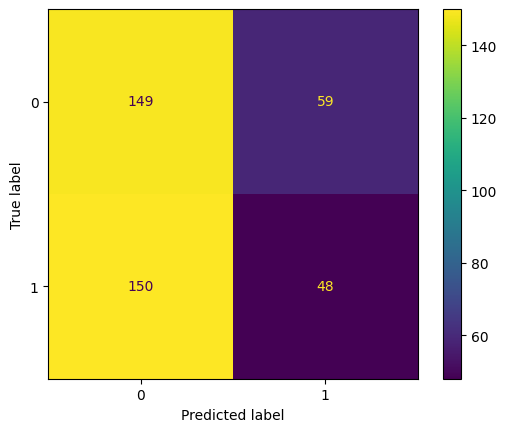

In [39]:
evaluate_classification(y_test, y_pred)

### Time Series Split Test


In [28]:
from sklearn.model_selection import TimeSeriesSplit

def expanding_window(model, X_train, y_train, window_size):
  predictions = []
  actuals = []
  size = len(df.loc[df['year'] < 2022].index)
  size_max = len(df)

  #tscv = TimeSeriesSplit(n_splits=len(X_train) - window_size, test_size = window_size)
  tscv = TimeSeriesSplit(n_splits=(int(-(size-size_max)/window_size)), test_size = window_size)

  for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"N: {i}")
    print(f"  Train: index={train_index} - {train_index.size}")
    print(f"  Test:  index={test_index} - {test_index.size} ")

    X_train_window, X_test_window = X_train[train_index], X_train[test_index]
    y_train_window, y_test_window = y_train[train_index], y_train[test_index]

    model.fit(X_train_window, y_train_window)
    y_pred = model.predict(X_test_window)

    predictions.extend(y_pred)
    actuals.extend(y_test_window)

  #model.fit(X_train, y_train)
  #y_pred_test = model.predict(X_test)
  #predictions.extend(y_pred_test)
  #actuals.extend(y_test)
  return np.array(predictions), np.array(actuals)

## Hyperparameters

In [87]:
from sklearn.model_selection import RandomizedSearchCV
import random

param_dist = {'n_estimators': np.arange(50,1400),
              'max_depth': np.arange(1,100)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=8,
                                 cv=6)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=6, estimator=RandomForestClassifier(), n_iter=8,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'n_estimators': array([  50,   51,   52, ..., 1397, 1398, 1399])})

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

Accuracy: 0.4852216748768473
Precision: 0.4485981308411215
Recall: 0.24242424242424243
AUC: 0.4793851981351982


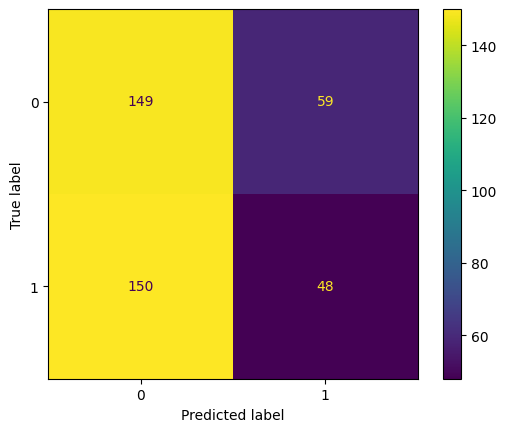

In [40]:
evaluate_classification(y_test, y_pred)

## Generate Output

In [ ]:
def generate_output(y_test, y_pred):

  testDate = y_test.reset_index()
  testDate = testDate['Date'].dt.strftime('%Y%m%d')
  testDate = pd.DataFrame(testDate)

  output = pd.concat([pd.DataFrame(testDate), pd.DataFrame(y_pred, columns = ['Prediction'])], axis=1)

  compression_opts = dict(method='zip', archive_name='output.csv')
  output.to_csv('output.zip', index=False, compression=compression_opts)
  return output

## Time Series Split

In [34]:
from sklearn.model_selection import TimeSeriesSplit

def expanding_window(model, X_train, y_train, window_size):

    predictions = []
    actuals = []
    size = len(df.loc[df['year'] < 2022].index)
    size_max =  len(df)
    i = 0

    idx = np.arange(len(X_train))
    train_starts = range(size, size_max, window_size)

    print(f"{size} {size_max}")

    for train_start in train_starts:

        train_idx = idx[:train_start]
        test_idx = idx[train_start : train_start + window_size]

        X_train_window, X_test_window = X_train[:train_start], X_train[train_start : train_start + window_size]
        y_train_window, y_test_window = y_train[:train_start], y_train[train_start : train_start + window_size]

        print(f"Fold: {i}")
        print(f"Train: index={train_idx} - Size: {train_idx.size}")
        print(f"Test:  index={test_idx} - Size: {test_idx.size} \n")

        model.fit(X_train_window, y_train_window)
        y_pred_window = model.predict(X_test_window)

        i+=1
        predictions.extend(y_pred_window)
        actuals.extend(y_test_window)

    return np.array(predictions), np.array(actuals)


In [12]:
y = df['Output']
X = df.drop(['Output', 'Return'], axis="columns")

### Time Series Split (22 Days)

In [21]:
# Feature Scaling
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=1111)
y_pred_window, y_test_window = expanding_window(classifier, X, y, window_size=22)

2853 3259
Fold: 0
  Train: index=[   0    1    2 ... 2850 2851 2852] - 2853
  Test:  index=[2853 2854 2855 2856 2857 2858 2859 2860 2861 2862 2863 2864 2865 2866
 2867 2868 2869 2870 2871 2872 2873 2874] - 22 

Fold: 1
  Train: index=[   0    1    2 ... 2872 2873 2874] - 2875
  Test:  index=[2875 2876 2877 2878 2879 2880 2881 2882 2883 2884 2885 2886 2887 2888
 2889 2890 2891 2892 2893 2894 2895 2896] - 22 

Fold: 2
  Train: index=[   0    1    2 ... 2894 2895 2896] - 2897
  Test:  index=[2897 2898 2899 2900 2901 2902 2903 2904 2905 2906 2907 2908 2909 2910
 2911 2912 2913 2914 2915 2916 2917 2918] - 22 

Fold: 3
  Train: index=[   0    1    2 ... 2916 2917 2918] - 2919
  Test:  index=[2919 2920 2921 2922 2923 2924 2925 2926 2927 2928 2929 2930 2931 2932
 2933 2934 2935 2936 2937 2938 2939 2940] - 22 

Fold: 4
  Train: index=[   0    1    2 ... 2938 2939 2940] - 2941
  Test:  index=[2941 2942 2943 2944 2945 2946 2947 2948 2949 2950 2951 2952 2953 2954
 2955 2956 2957 2958 2959 2960 296

Accuracy: 0.49014778325123154
Precision: 0.4676258992805755
Recall: 0.3282828282828283
AUC: 0.4862567987567987


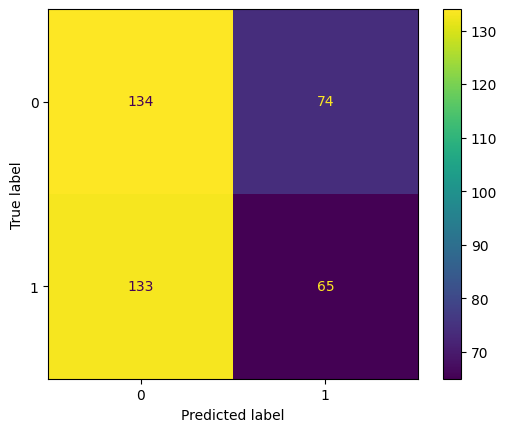

In [27]:
evaluate_classification(y_test_window, y_pred_window)

### Time Series Split (5 Days)

In [28]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=1111)
y_pred_window, y_test_window = expanding_window(classifier, X, y, window_size=5)

2853 3259
Fold: 0
  Train: index=[   0    1    2 ... 2850 2851 2852] - 2853
  Test:  index=[2853 2854 2855 2856 2857] - 5 

Fold: 1
  Train: index=[   0    1    2 ... 2855 2856 2857] - 2858
  Test:  index=[2858 2859 2860 2861 2862] - 5 

Fold: 2
  Train: index=[   0    1    2 ... 2860 2861 2862] - 2863
  Test:  index=[2863 2864 2865 2866 2867] - 5 

Fold: 3
  Train: index=[   0    1    2 ... 2865 2866 2867] - 2868
  Test:  index=[2868 2869 2870 2871 2872] - 5 

Fold: 4
  Train: index=[   0    1    2 ... 2870 2871 2872] - 2873
  Test:  index=[2873 2874 2875 2876 2877] - 5 

Fold: 5
  Train: index=[   0    1    2 ... 2875 2876 2877] - 2878
  Test:  index=[2878 2879 2880 2881 2882] - 5 

Fold: 6
  Train: index=[   0    1    2 ... 2880 2881 2882] - 2883
  Test:  index=[2883 2884 2885 2886 2887] - 5 

Fold: 7
  Train: index=[   0    1    2 ... 2885 2886 2887] - 2888
  Test:  index=[2888 2889 2890 2891 2892] - 5 

Fold: 8
  Train: index=[   0    1    2 ... 2890 2891 2892] - 2893
  Test:  ind

Accuracy: 0.5073891625615764
Precision: 0.4931506849315068
Recall: 0.36363636363636365
AUC: 0.5039335664335665


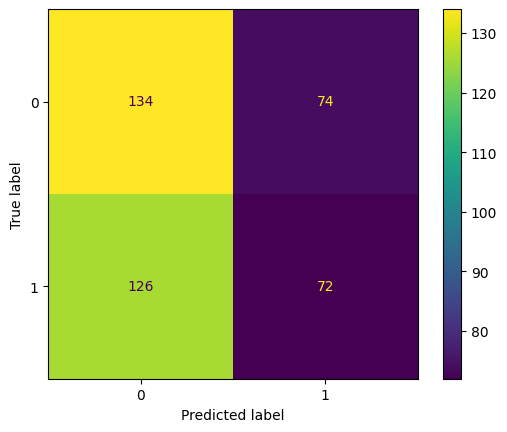

In [29]:
evaluate_classification(y_test_window, y_pred_window)

### Time Series Split (1 Days)

In [30]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=1111)
y_pred_window, y_test_window = expanding_window(classifier, X, y, window_size=1)

2853 3259
Fold: 0
  Train: index=[   0    1    2 ... 2850 2851 2852] - 2853
  Test:  index=[2853] - 1 

Fold: 1
  Train: index=[   0    1    2 ... 2851 2852 2853] - 2854
  Test:  index=[2854] - 1 

Fold: 2
  Train: index=[   0    1    2 ... 2852 2853 2854] - 2855
  Test:  index=[2855] - 1 

Fold: 3
  Train: index=[   0    1    2 ... 2853 2854 2855] - 2856
  Test:  index=[2856] - 1 

Fold: 4
  Train: index=[   0    1    2 ... 2854 2855 2856] - 2857
  Test:  index=[2857] - 1 

Fold: 5
  Train: index=[   0    1    2 ... 2855 2856 2857] - 2858
  Test:  index=[2858] - 1 

Fold: 6
  Train: index=[   0    1    2 ... 2856 2857 2858] - 2859
  Test:  index=[2859] - 1 

Fold: 7
  Train: index=[   0    1    2 ... 2857 2858 2859] - 2860
  Test:  index=[2860] - 1 

Fold: 8
  Train: index=[   0    1    2 ... 2858 2859 2860] - 2861
  Test:  index=[2861] - 1 

Fold: 9
  Train: index=[   0    1    2 ... 2859 2860 2861] - 2862
  Test:  index=[2862] - 1 

Fold: 10
  Train: index=[   0    1    2 ... 2860 2

Accuracy: 0.5541871921182266
Precision: 0.5648854961832062
Recall: 0.37373737373737376
AUC: 0.549849456099456


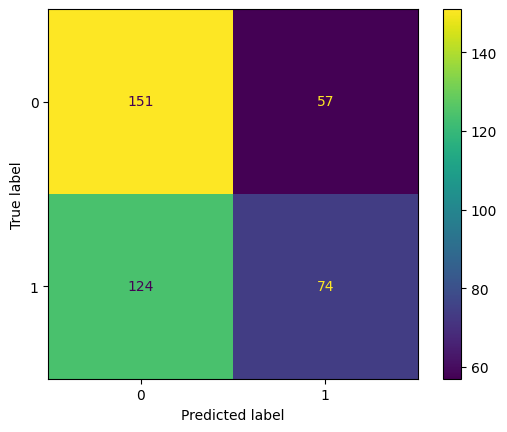

In [31]:
evaluate_classification(y_test_window, y_pred_window)

## Baseline

In [77]:
X_train, y_train, X_test, y_test = split_data(df)

In [88]:
y_pred_base_classifier = pd.DataFrame(y_test)
y_pred_base_classifier.value_counts()

Output
0         208
1         198
dtype: int64

In [89]:
y_pred_base_classifier['Output'] = 0
y_pred_base_classifier

,Output
Date,
2022-01-03 16:56:00,0
2022-01-04 16:56:00,0
2022-01-05 16:56:00,0
2022-01-06 16:56:00,0
2022-01-07 16:56:00,0
...,...
2023-08-10 16:56:00,0
2023-08-11 16:56:00,0
2023-08-14 16:56:00,0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5123152709359606
Precision: 0.0
Recall: 0.0
AUC: 0.5


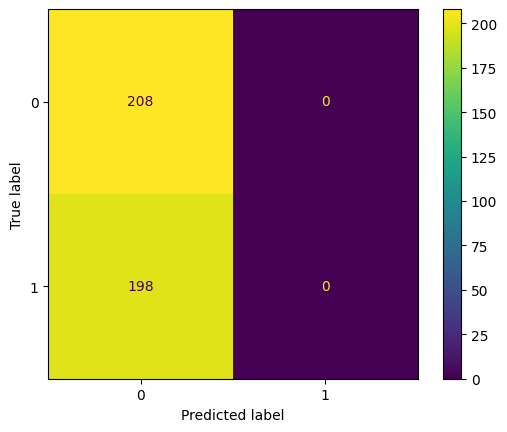

In [90]:
evaluate_classification(y_test, y_pred_base_classifier)

# MLP

In [41]:
X_train, y_train, X_test, y_test = split_data(df)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Holdout

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_regressor(y_test, y_pred):
  test_set_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print('RMSE: ', test_set_rmse)

  mae = mean_absolute_error(y_test, y_pred)
  print("MAE = ", mae)

In [52]:
from sklearn.neural_network import MLPRegressor

# Initializing the MLP Regressor
regressor = MLPRegressor(hidden_layer_sizes=(5), max_iter=800,solver='adam',random_state=1111)

# Fitting MLP Regressor to the Training Set
regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = regressor.predict(X_test)

# Evaluate
evaluate_regressor(y_test, y_pred)

RMSE:  760.2411283888366
MAE =  665.7463357247783


## Time Series Split

In [47]:
y = df['Output']
X = df.drop(['Output', 'Return'], axis="columns")

### Time Series Split (22 Days)

In [49]:
regressor = MLPRegressor(hidden_layer_sizes=(5), max_iter=800,solver='adam',random_state=1111)
y_pred_window, y_test_window = expanding_window(classifier, X, y, window_size=22)

2853 3259
Fold: 0
Train: index=[   0    1    2 ... 2850 2851 2852] - Size: 2853
Test:  index=[2853 2854 2855 2856 2857 2858 2859 2860 2861 2862 2863 2864 2865 2866
 2867 2868 2869 2870 2871 2872 2873 2874] - Size: 22 

Fold: 1
Train: index=[   0    1    2 ... 2872 2873 2874] - Size: 2875
Test:  index=[2875 2876 2877 2878 2879 2880 2881 2882 2883 2884 2885 2886 2887 2888
 2889 2890 2891 2892 2893 2894 2895 2896] - Size: 22 

Fold: 2
Train: index=[   0    1    2 ... 2894 2895 2896] - Size: 2897
Test:  index=[2897 2898 2899 2900 2901 2902 2903 2904 2905 2906 2907 2908 2909 2910
 2911 2912 2913 2914 2915 2916 2917 2918] - Size: 22 

Fold: 3
Train: index=[   0    1    2 ... 2916 2917 2918] - Size: 2919
Test:  index=[2919 2920 2921 2922 2923 2924 2925 2926 2927 2928 2929 2930 2931 2932
 2933 2934 2935 2936 2937 2938 2939 2940] - Size: 22 

Fold: 4
Train: index=[   0    1    2 ... 2938 2939 2940] - Size: 2941
Test:  index=[2941 2942 2943 2944 2945 2946 2947 2948 2949 2950 2951 2952 2953 2954


In [53]:
evaluate_regressor(y_test_window, y_pred_window)

RMSE:  0.7140393663858936
MAE =  0.5098522167487685


### Time Series Split (5 Days)

In [55]:
regressor = MLPRegressor(hidden_layer_sizes=(5), max_iter=200,solver='adam',random_state=1111)
y_pred_window, y_test_window = expanding_window(classifier, X, y, window_size=5)
evaluate_regressor(y_test_window, y_pred_window)

2853 3259
Fold: 0
Train: index=[   0    1    2 ... 2850 2851 2852] - Size: 2853
Test:  index=[2853 2854 2855 2856 2857] - Size: 5 

Fold: 1
Train: index=[   0    1    2 ... 2855 2856 2857] - Size: 2858
Test:  index=[2858 2859 2860 2861 2862] - Size: 5 

Fold: 2
Train: index=[   0    1    2 ... 2860 2861 2862] - Size: 2863
Test:  index=[2863 2864 2865 2866 2867] - Size: 5 

Fold: 3
Train: index=[   0    1    2 ... 2865 2866 2867] - Size: 2868
Test:  index=[2868 2869 2870 2871 2872] - Size: 5 

Fold: 4
Train: index=[   0    1    2 ... 2870 2871 2872] - Size: 2873
Test:  index=[2873 2874 2875 2876 2877] - Size: 5 

Fold: 5
Train: index=[   0    1    2 ... 2875 2876 2877] - Size: 2878
Test:  index=[2878 2879 2880 2881 2882] - Size: 5 

Fold: 6
Train: index=[   0    1    2 ... 2880 2881 2882] - Size: 2883
Test:  index=[2883 2884 2885 2886 2887] - Size: 5 

Fold: 7
Train: index=[   0    1    2 ... 2885 2886 2887] - Size: 2888
Test:  index=[2888 2889 2890 2891 2892] - Size: 5 

Fold: 8
Train:

### Time Series Split (1 Days)

In [56]:
regressor = MLPRegressor(hidden_layer_sizes=(5), max_iter=200,solver='adam',random_state=1111)
y_pred_window, y_test_window = expanding_window(classifier, X, y, window_size=1)
evaluate_regressor(y_test_window, y_pred_window)

2853 3259
Fold: 0
Train: index=[   0    1    2 ... 2850 2851 2852] - Size: 2853
Test:  index=[2853] - Size: 1 

Fold: 1
Train: index=[   0    1    2 ... 2851 2852 2853] - Size: 2854
Test:  index=[2854] - Size: 1 

Fold: 2
Train: index=[   0    1    2 ... 2852 2853 2854] - Size: 2855
Test:  index=[2855] - Size: 1 

Fold: 3
Train: index=[   0    1    2 ... 2853 2854 2855] - Size: 2856
Test:  index=[2856] - Size: 1 

Fold: 4
Train: index=[   0    1    2 ... 2854 2855 2856] - Size: 2857
Test:  index=[2857] - Size: 1 

Fold: 5
Train: index=[   0    1    2 ... 2855 2856 2857] - Size: 2858
Test:  index=[2858] - Size: 1 

Fold: 6
Train: index=[   0    1    2 ... 2856 2857 2858] - Size: 2859
Test:  index=[2859] - Size: 1 

Fold: 7
Train: index=[   0    1    2 ... 2857 2858 2859] - Size: 2860
Test:  index=[2860] - Size: 1 

Fold: 8
Train: index=[   0    1    2 ... 2858 2859 2860] - Size: 2861
Test:  index=[2861] - Size: 1 

Fold: 9
Train: index=[   0    1    2 ... 2859 2860 2861] - Size: 2862
Te

## Baseline

In [79]:
X_train, y_train, X_test, y_test = split_data(df)

In [80]:
y_pred_base_regressor = pd.DataFrame(y_test).shift(1, fill_value=0)
y_pred_base_regressor

,Output
Date,
2022-01-03 16:56:00,0
2022-01-04 16:56:00,0
2022-01-05 16:56:00,1
2022-01-06 16:56:00,0
2022-01-07 16:56:00,0
...,...
2023-08-10 16:56:00,0
2023-08-11 16:56:00,1
2023-08-14 16:56:00,1


In [81]:
evaluate_regressor(y_test, y_pred_base_regressor)

RMSE:  0.6858887298634484
MAE =  0.47044334975369456
